In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import datasets
from tensorflow.python.framework import ops
ops.reset_default_graph()
sess = tf.Session()

/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.25.3) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
import pandas as pd                                 #importing dataframes
import librosa as lr                                #feature extraction(read and manipulate audio files)
import soundfile as sf
import os

In [3]:
def extract_feature(file):
    X, sample_rate = sf.read(file, dtype='float32')
    if X.ndim > 1: X = X[:,0]
    X = X.T

    mfccs = np.mean(lr.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    return list(mfccs)

In [4]:
features = [feature for feature in os.listdir('Binary') if feature[0] != '.' and os.path.isdir(f'Binary/{feature}')]
label_map = { i: value for i, value in enumerate(features) }
label_map_inverse = { value: i for i, value in enumerate(features) }

In [5]:
in_out = []
for feature in features:
    base = f'Binary/{feature}'
    for data in os.listdir(base):
        with open(f"{base}/{data}", "rb") as file:
            X = extract_feature(file)
        X.append(label_map_inverse[feature])
        in_out.append(X)

In [6]:
arr = np.array(in_out)
X, Y = arr[:, :-1], arr[:, -1]

In [7]:
X = X.astype('float32')

In [46]:
len(X)
tf.shape(X)

<tf.Tensor 'Shape:0' shape=(2,) dtype=int32>

In [9]:
batch_size = len(X)

x_data = tf.placeholder(shape=[None, 40], dtype=tf.float32)
y_target = tf.placeholder(shape=[2, None], dtype=tf.float32)
prediction_grid = tf.placeholder(shape=[None, 40], dtype=tf.float32)

b = tf.Variable(tf.random_normal(shape=[2,batch_size]))


## Linear Kernal
k(x)= x.T*x

In [10]:
my_kernel = tf.matmul(x_data, tf.transpose(x_data))

In [11]:
def reshape_matmul(mat):
    v1 = tf.expand_dims(mat, 1)
    v2 = tf.reshape(v1, [2, batch_size, 1])
    return(tf.matmul(v2, v1))

In [12]:
first_term = tf.reduce_sum(b)
b_vec_cross = tf.matmul(tf.transpose(b), b)
y_target_cross = reshape_matmul(y_target)

second_term = tf.reduce_sum(tf.multiply(my_kernel, tf.multiply(b_vec_cross, y_target_cross)),[1,2])
loss = tf.reduce_sum(tf.negative(tf.subtract(first_term, second_term)))

In [14]:
prediction_output = tf.matmul(tf.multiply(y_target,b), my_kernel)
prediction = tf.argmax(prediction_output-tf.expand_dims(tf.reduce_mean(prediction_output,1), 1), 0)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, tf.argmax(y_target,0)), tf.float32))

In [26]:
my_opt = tf.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)

init = tf.global_variables_initializer()
sess.run(init)

In [27]:
X[1998]

array([-117.04172   ,   98.74411   ,   -7.84117   ,   25.003645  ,
        -11.697216  ,    0.80795455,   -7.054726  ,   -4.355222  ,
         17.529219  ,   -8.075153  ,   -8.070326  ,   -4.624619  ,
          2.2866275 ,    7.9110107 ,   -4.815217  ,    5.0578566 ,
         -4.4488797 ,    5.615981  ,   -5.111008  ,   -0.34769535,
          0.9868414 ,    9.099472  ,    7.043878  ,   17.930199  ,
          8.818103  ,   21.00118   ,    3.7422137 ,   -1.2640274 ,
         -5.666455  ,    0.14610142,    2.0820558 ,    4.2920456 ,
         -5.5295887 ,   -3.3003354 ,   -5.073157  ,    5.700756  ,
         -6.103286  ,   -6.193521  ,  -10.946615  ,    0.9183802 ],
      dtype=float32)

In [28]:
Y_cat = tf.keras.utils.to_categorical(Y).T

In [29]:
loss_vec = []
batch_accuracy = []
for i in range(100):
    rand_index = np.random.choice(len(X), size=batch_size)
    rand_x = X[rand_index]
    rand_y = Y_cat[:, rand_index]    
    
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})

    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)

    acc_temp = sess.run(accuracy, feed_dict={x_data: rand_x,
                                             y_target: rand_y,
                                             prediction_grid:rand_x})
    batch_accuracy.append(acc_temp)

    if (i+1)%10==0:
        print('Step #' + str(i+1))
        print('Loss = ' + str(temp_loss))

Step #10
Loss = 59484056.0
Step #20
Loss = 83062900.0
Step #30
Loss = 743760700.0
Step #40
Loss = 485409900.0
Step #50
Loss = 138885090.0
Step #60
Loss = 111359640.0
Step #70
Loss = 162318620.0
Step #80
Loss = 27229444.0
Step #90
Loss = 64206052.0
Step #100
Loss = 57486816.0


In [30]:
saver = tf.train.Saver()

In [31]:
saver.save(sess, './my-model-linear')

'./my-model-linear'

In [32]:
max(batch_accuracy)

0.9051315

In [39]:
tf.saved_model.simple_save(sess,
            './savedmodel/',
            inputs={"x": x_data,},
            outputs={"y_pred": y_target,
                     "y_pred_cls": prediction_grid})

W0730 14:24:02.758044 139944323303232 deprecation.py:323] From <ipython-input-39-30d3f7b333e9>:5: simple_save (from tensorflow.python.saved_model.simple_save) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
W0730 14:24:02.761802 139944323303232 deprecation.py:323] From /home/bhrigu/.local/lib/python3.6/site-packages/tensorflow/python/saved_model/signature_def_utils_impl.py:201: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


In [ ]:
# restoring_graph = tf.Graph()
# with restoring_graph.as_default():
#     with tf.Session(graph=restoring_graph) as sess:
#        # Restore saved values
#        tf.saved_model.loader.load(
#           sess,
#           [tag_constants.TRAINING],
#           export_dir  # Path to SavedModel
#        )
#       # Pass inputs to model and do predictions below

In [ ]:
!tflite_convert \
--output_file "celestini.tflite" \
--graph_def_file "./litemodel/saved_model.pb" \
--input_arrays "x_data" \
--output_arrays "y_target" 

In [43]:
tflite_convert \
  --output_file=./litemodel/celestini.tflite \
  --saved_model_dir=./savedmodel/saved_model.pb

IndentationError: unexpected indent (<ipython-input-43-892dd5781529>, line 2)

In [47]:
path_to_graphdef_pb = '...'
g = tf.GraphDef()
with open(path_to_graphdef_pb, 'rb') as f:
  g.ParseFromString(f.read())
output_node_names = ["..."]
input_tensors = [..]
output_tensors = [...]

with tf.Session(graph=g) as sess:
  frozen_graph_def = tf.graph_util.convert_variables_to_constants(
      sess, sess.graph_def, output_node_names)
# Note here we are passing frozen_graph_def obtained in the previous step to toco.
tflite_model = tf.contrib.lite.toco_convert(frozen_graph_def, input_tensors, output_tensors)

W0730 16:28:14.736054 139944323303232 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



AttributeError: module 'tensorflow.contrib' has no attribute 'lite'

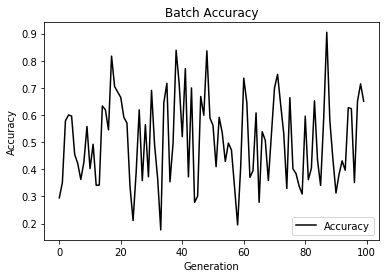

In [33]:
plt.plot(batch_accuracy, 'k-', label='Accuracy')
plt.title('Batch Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [55]:
def load_graph(frozen_graph_filename):
    # We load the protobuf file from the disk and parse it to retrieve the 
    # unserialized graph_def
    with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

    # Then, we import the graph_def into a new Graph and return it 
    with tf.Graph().as_default() as graph:
        # The name var will prefix every op/nodes in your graph
        # Since we load everything in a new graph, this is not needed
        tf.import_graph_def(graph_def, name="prefix")
    return graph

newgraph = load_graph('./litemodel/saved_model.pb')

NotFoundError: ./litemodel/saved_model.pb; No such file or directory

In [52]:
for op in graph.get_operations(): 
    print (op.name(), op.value())

NameError: name 'graph' is not defined